# EDA PURE

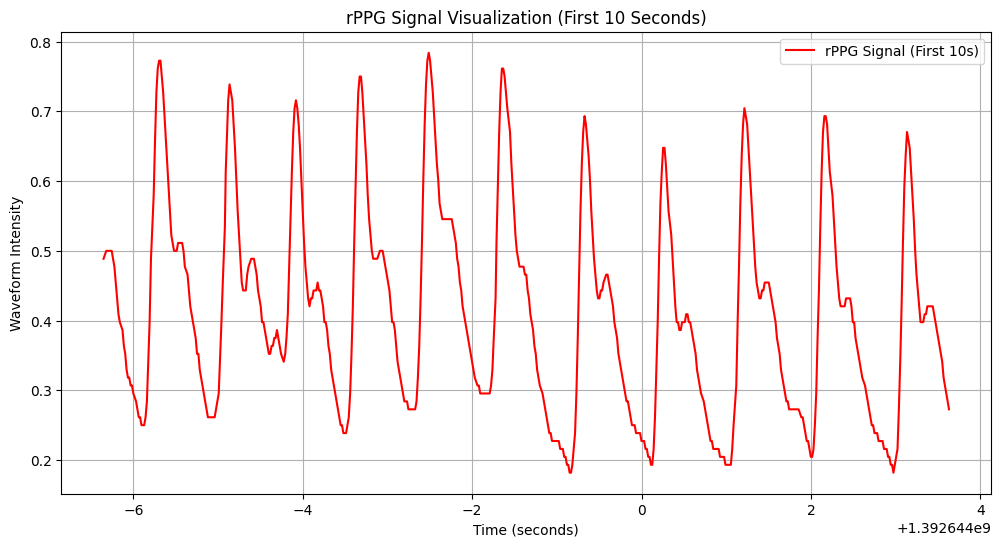

In [2]:
# Re-load necessary libraries after execution state reset
import json
import matplotlib.pyplot as plt
import numpy as np

# Define the file path
file_path = "/Volumes/T5 EVO/PURE/01-01.json"

# Load JSON data
with open(file_path, "r") as f:
    data = json.load(f)

# Extract timestamps and waveform values
timestamps = []
waveforms = []

for entry in data["/FullPackage"]:
    timestamps.append(entry["Timestamp"] / 1e9)  # Convert to seconds
    waveforms.append(entry["Value"]["waveform"])

# Convert to NumPy arrays
timestamps = np.array(timestamps)
waveforms = np.array(waveforms)

# Normalize waveform (optional)
waveforms = (waveforms - np.min(waveforms)) / (np.max(waveforms) - np.min(waveforms))

# Select first 10 seconds of data
start_time = timestamps[0]
end_time = start_time + 10  # 10 seconds later
mask = (timestamps >= start_time) & (timestamps <= end_time)

timestamps_10s = timestamps[mask]
waveforms_10s = waveforms[mask]

# Plot the rPPG signal (10s)
plt.figure(figsize=(12, 6))
plt.plot(timestamps_10s, waveforms_10s, color='red', label="rPPG Signal (First 10s)")
plt.xlabel("Time (seconds)")
plt.ylabel("Waveform Intensity")
plt.title("rPPG Signal Visualization (First 10 Seconds)")
plt.legend()
plt.grid()
plt.show()


SDNN: 56.42 ms
RMSSD: 45.58 ms
pNN50: 11.84 %


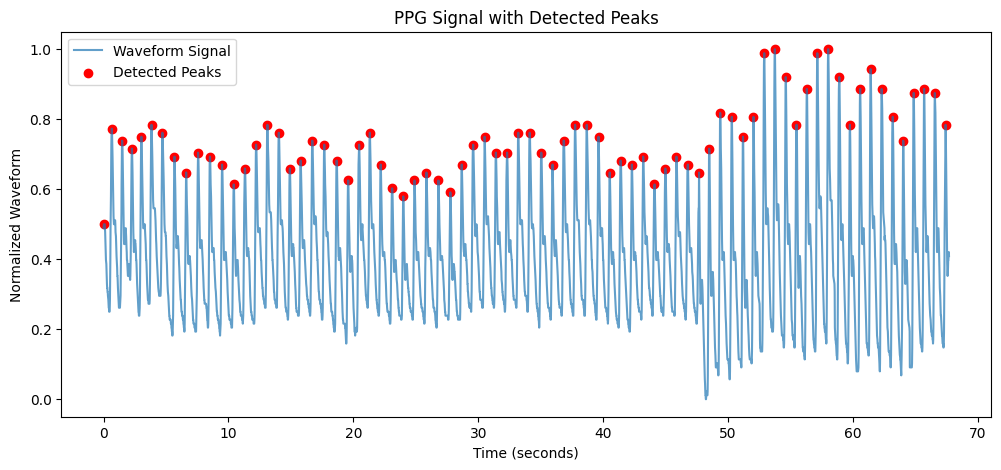

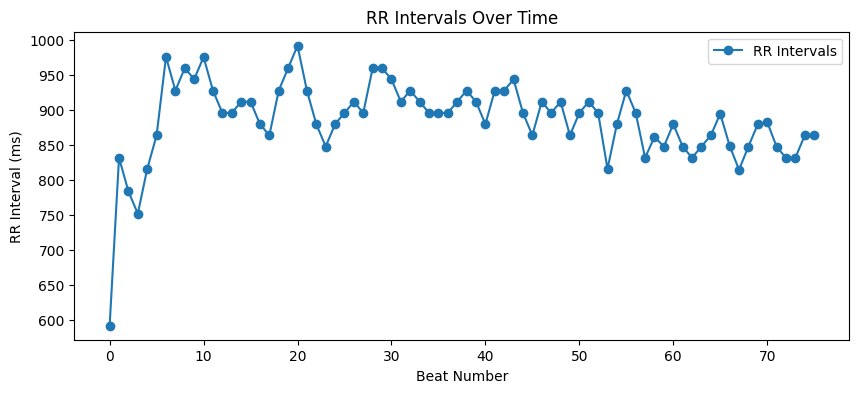

In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# 读取 JSON 文件
file_path = "/Volumes/T5 EVO/PURE/01-01.json"
with open(file_path, "r") as f:
    data = json.load(f)["/FullPackage"]

# 解析时间戳和 PPG 波形
timestamps = np.array([entry["Timestamp"] for entry in data]) / 1e9  # 转换为秒
waveform = np.array([entry["Value"]["waveform"] for entry in data])

# 归一化波形以提高峰值检测准确度
waveform = (waveform - np.min(waveform)) / (np.max(waveform) - np.min(waveform))

# 检测心跳峰值
peaks, _ = find_peaks(waveform, distance=30, height=0.5)  # `distance` 设定心跳最小间隔（调整参数）

# 计算 RR 间期（心跳间隔，单位：毫秒）
rr_intervals = np.diff(timestamps[peaks]) * 1000  # 转换为毫秒

# 计算 HRV 指标
sdnn = np.std(rr_intervals)  # SDNN
rmssd = np.sqrt(np.mean(np.diff(rr_intervals) ** 2))  # RMSSD
pnn50 = np.sum(np.abs(np.diff(rr_intervals)) > 50) / len(rr_intervals) * 100  # pNN50

# 输出 HRV 结果
print(f"SDNN: {sdnn:.2f} ms")
print(f"RMSSD: {rmssd:.2f} ms")
print(f"pNN50: {pnn50:.2f} %")

# 可视化波形和检测到的心跳
plt.figure(figsize=(12, 5))
plt.plot(timestamps - timestamps[0], waveform, label="Waveform Signal", alpha=0.7)
plt.scatter((timestamps[peaks] - timestamps[0]), waveform[peaks], color="red", label="Detected Peaks")
plt.xlabel("Time (seconds)")
plt.ylabel("Normalized Waveform")
plt.title("PPG Signal with Detected Peaks")
plt.legend()
plt.show()

# 可视化 RR 间期
plt.figure(figsize=(10, 4))
plt.plot(rr_intervals, marker="o", linestyle="-", label="RR Intervals")
plt.xlabel("Beat Number")
plt.ylabel("RR Interval (ms)")
plt.title("RR Intervals Over Time")
plt.legend()
plt.show()


# get video

In [ ]:
import os
import glob
import cv2
import numpy as np

# PURE 数据集路径
video_DIR = "/Volumes/T5 EVO/PURE/"

# 视频帧率
frameRate = 30.0

def sort_nicely(l):
    """ 按照人类习惯的方式对文件名排序 """
    import re
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    l.sort(key=alphanum_key)
    return l

def loadFrames(directorypath):
    """ 从目录加载 PNG 图像帧 """
    f_names = sort_nicely(os.listdir(directorypath))  # 按顺序获取 PNG 图片
    frames = []
    for filename in f_names:
        full_path = os.path.join(directorypath, filename)
        frame = cv2.imread(full_path)
        if frame is not None:
            frames.append(frame[:, :, ::-1])  # 读取并转换颜色格式
    return np.array(frames)

# 遍历数据集目录
for root, dirs, files in os.walk(video_DIR):
    for d in dirs:
        subject_path = os.path.join(root, d)
        avi_path = os.path.join(subject_path, d + '.avi')

        # 检查是否已经存在 AVI 文件
        if not glob.glob(subject_path + "/*.avi"):
            print(f"正在处理 subject: {d} -> 生成 {avi_path}")

            frames = loadFrames(subject_path)
            if len(frames) == 0:
                print(f"❌ {d} 没有找到 PNG 图片，跳过。")
                continue

            # 获取第一帧的尺寸
            height, width = frames[0].shape[:2]

            # 创建 AVI 视频
            writer = cv2.VideoWriter(avi_path, 0, frameRate, (width, height))

            # 写入帧
            for frame in frames:
                writer.write(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

            writer.release()
            print(f"✅ {d} AVI 视频生成完成！")
        else:
            print(f"⚠️ {d} 的 AVI 视频已存在，跳过处理。")


In [3]:
!pip install opencv-python


  Using cached opencv_python-4.11.0.86-cp37-abi3-macosx_13_0_arm64.whl.metadata (20 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-macosx_13_0_arm64.whl (37.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 14.7 MB/s eta 0:00:00a 0:00:01


In [4]:
import cv2
import os
import glob

# 设置图片文件夹路径
image_folder = "/Volumes/T5 EVO/PURE/01-01"  # 替换为你的 PNG 图片路径
output_video = "output.avi"  # 输出的视频文件名
frame_rate = 30  # 设定帧率 (FPS)

# 获取所有 PNG 图片并按文件名排序
images = sorted(glob.glob(os.path.join(image_folder, "*.png")))

# 确保至少有一张图片
if not images:
    print("未找到 PNG 图片")
    exit()

# 读取第一张图片以获取视频尺寸
first_frame = cv2.imread(images[0])
height, width, _ = first_frame.shape
size = (width, height)

# 创建 VideoWriter 对象
fourcc = cv2.VideoWriter_fourcc(*"XVID")  # 使用 XVID 编码
out = cv2.VideoWriter(output_video, fourcc, frame_rate, size)

# 逐帧写入 AVI 文件
for image in images:
    frame = cv2.imread(image)
    if frame is None:
        continue
    out.write(frame)

# 释放资源
out.release()
print(f"视频已保存为 {output_video}")



视频已保存为 output.avi


In [6]:
import cv2
import os
import glob

# Set your image folder
image_folder = "/Volumes/T5 EVO/PURE/02-05"  # Replace with your actual path
output_video = "/Volumes/T5 EVO/PURE/02-05.mp4"  # Save as MP4 instead of AVI
frame_rate = 30  # FPS setting

# Get all PNG files and sort them
images = sorted(glob.glob(os.path.join(image_folder, "*.png")))

if not images:
    print("No PNG images found!")
    exit()

# Read the first frame to get the video size
first_frame = cv2.imread(images[0])
height, width, _ = first_frame.shape
size = (width, height)

# Change codec to H.264 (for MP4 output)
fourcc = cv2.VideoWriter_fourcc(*"mp4v")  
out = cv2.VideoWriter(output_video, fourcc, frame_rate, size)

# Process images and create video
for image in images:
    frame = cv2.imread(image)
    if frame is None:
        continue
    out.write(frame)

# Release resources
out.release()
print(f"Video saved as {output_video}")


Video saved as /Volumes/T5 EVO/PURE/02-05.mp4
